# Causal Data Science Week 5 Tutorial

In this tutorial we will practice how to learn a causal graph from constraint based structure learning with the PC algorithm. We will go through the algorithm both by-hand and with the CausalDiscoveryTool package.

## SGS and PC algorithm

The PC algorithm is a constraint based causal discovery algorithm named after its authors **P**eter Spirtes and **C**lark Glymour. The idea of this algorithm is based on conditional independence testing. 

For the simplicity of coding, we will start with a simpler version called SGS algorithm (https://www.researchgate.net/publication/242448131_Causation_Prediction_and_Search). SGS algorithm has the same input/output relations as the PC algorithm for faithful distributions, but has higher complexity as it tests more conditional independences. While the SGS algorithm always considers all possible pairs of nodes in the graph, the PC algorithm only considers adjacent pairs of nodes

Assuming Markov and faithfulness, a CPDAG (completed partially directed acyclic graph) can be estimated. Both algorithms proceed as follows:
- Determine the skeleton
- Determine the v-structures
- Direct as many of the remaining edges as possible.

The implementation below is a naive version of SGS algorithm, where we check the v-structures and direct edges by hands. We go through an example with synthetic dataset. The example graph is taken from: https://stat.ethz.ch/lectures/ss21/causality.php#course_materials.

In [21]:
# import necessary packages
from itertools import combinations

import cdt
# cdt.SETTINGS.rpath = '/Library/Frameworks/R.framework/Resources/bin/R' # for macOS
# cdt.SETTINGS.rpath = 'C:/Program Files/R/R-4.0.3/bin/Rscript' # for Windows

from dowhy import CausalModel
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from numpy.random import normal
import pandas as pd
import pingouin as pg

np.random.seed(0)


We first ceate a synthetic dataset that contains 5 variables with linear dependencies between them according to the SCM below, where, each error term is drawn from an independent Gaussian distribution. We can use scatter plots to plot the relationship between any two variables.
$$
\begin{aligned}
X_1 &\leftarrow \epsilon_1 & \epsilon_1 &\sim \mathcal N(0,1)\\
X_2 &\leftarrow \epsilon_2 & \epsilon_2 &\sim \mathcal N(0,1)\\
X_3 &\leftarrow X_1 + X_2 + \epsilon_3 & \epsilon_3 &\sim \mathcal N(0,0.7)\\
X_4 &\leftarrow 2 X_1 + \epsilon_4 & \epsilon_4 &\sim \mathcal N(0,1.5)\\
X_5 &\leftarrow 3 X_3 + \epsilon_5 & \epsilon_5 &\sim \mathcal N(0,1)\\
\end{aligned}
$$

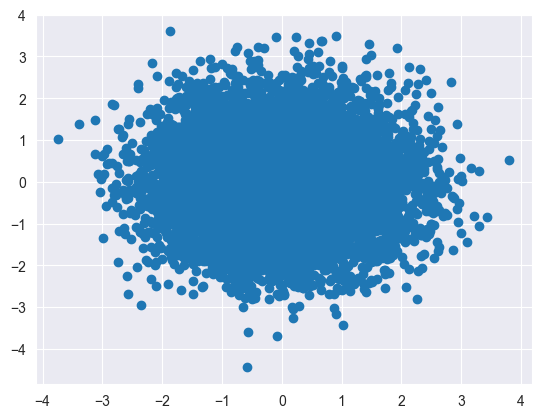

In [22]:
n_samples=10000

eps1 = normal(0, 1, n_samples)
eps2 = normal(0, 1, n_samples)
eps3 = normal(0, 0.7, n_samples)
eps4 = normal(0, 1.5, n_samples)
eps5 = normal(0, 1, n_samples)

x1 = eps1
x2 = eps2
x3 = x1 + x2 + eps3
x4 = 2 * x1 + eps4
x5 = 3 * x3 + eps5

# we can plot scatter plots between any two variables 
plt.scatter(x1, x2)

In [23]:
df = pd.DataFrame({'x1': x1,'x2': x2,'x3': x3,'x4': x4,'x5': x5})
df.head()

,x1,x2,x3,x4,x5
0,1.764052,-0.202117,1.792967,4.084953,3.439402
1,0.400157,-0.833231,-0.433410,1.257490,-0.561379
2,0.978738,1.733600,3.285019,2.713663,11.249743
3,2.240893,0.190649,2.731292,4.684736,7.380290
4,1.867558,-0.177810,-0.063016,4.715754,-1.007869


From the data simulation, we know the true underlying graph, while normally we do not have access. The true causal graph is as follows:

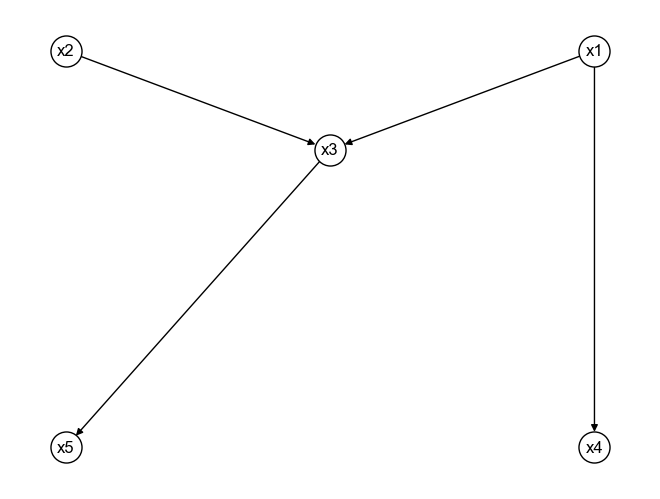

In [24]:
nodes = ["x1", "x2", "x3", "x4", "x5"]
pos = {'x2': (-1, 1), 'x1': (1, 1), 'x3': (0, 0.5), 'x4': (1, -1), 'x5': (-1, -1), }

true_graph = nx.DiGraph()
true_graph.add_nodes_from(nodes)
true_graph.add_edges_from([('x1', 'x3'), ('x2', 'x3'), ('x1', 'x4'), ('x3', 'x5')])

nx.draw(true_graph, with_labels=True, node_size=500, node_color='w', edgecolors='black', pos=pos)

### Determine the skeleton
The first step is to determine the skeleton. We start with the fully connected undirected graph. Then for $k = 0,1,...,|V|-2$, consider all pairs of vertices $(i, j)$, and remove the edge between them if $X_i$ and $X_j$ are conditionally independent given some subset $S\subseteq V\setminus\{i, j\}$ of size $k$.

We start with a fully connected undirected graph with $|V|=5$ nodes.

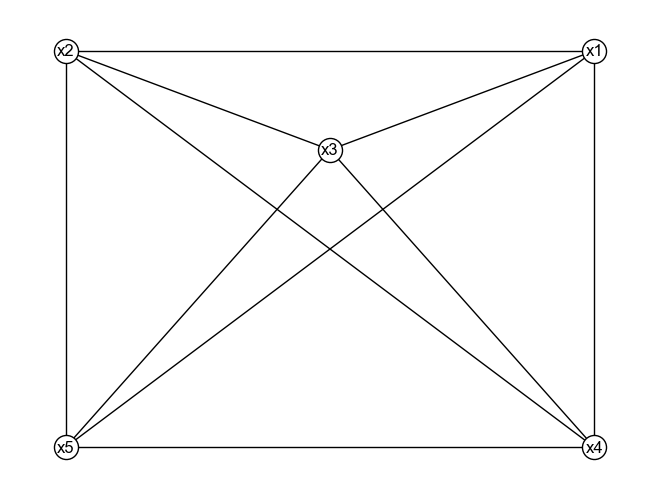

In [25]:
skeleton = nx.Graph()
skeleton.add_nodes_from(nodes)
skeleton.add_edges_from(combinations(nodes, 2))

nx.draw(skeleton, with_labels=True, node_color='w', edgecolors ='black', pos=pos)

We use conditional independence testing (Tutorial 2) between any pair of variables with a conditioning set of size $k=0$ (thus $S = \emptyset$). By default we use the significance level of 0.05. The Null hypothesis is $X \!\perp\!\!\!\perp Y$, while the alternative hypothesis is $X \not \!\perp\!\!\!\perp Y$. 

,n,r,CI95%,p-val
pearson,10000,-0.008,"[-0.03, 0.01]",0.438


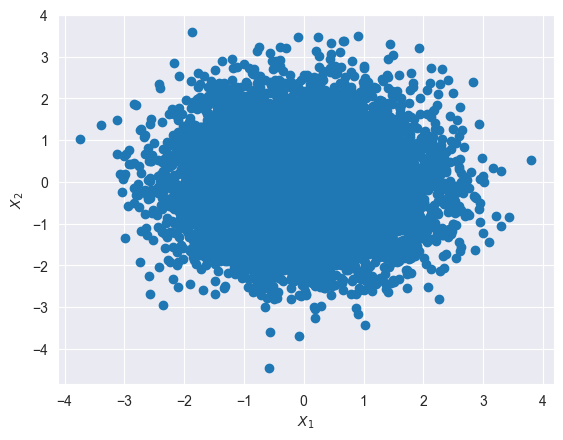

In [26]:
alpha = 0.05 # significance level

plt.scatter(x1, x2)
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
pg.partial_corr(data=df, x='x1', y='x2', covar=[]).round(3) 

The scatter plot, as well as the non-significant p-value (larger than $\alpha=0.05$) suggests that we fail to reject null hypothesis of independence; $X_1 \!\perp\!\!\!\perp X_2$, and therefore we remove the edge between the corresponding nodes.

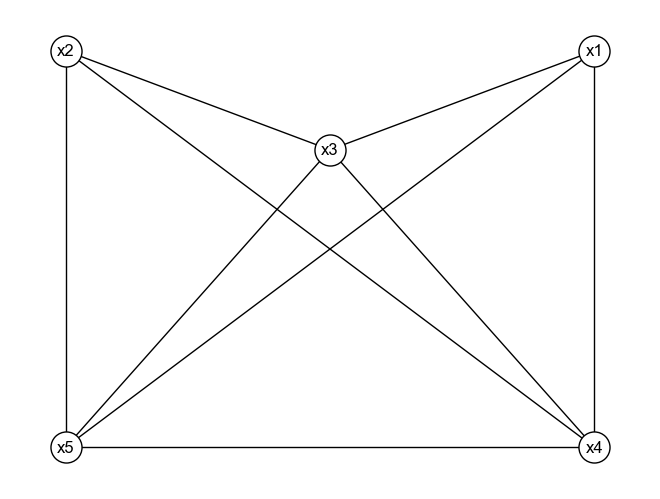

In [27]:
skeleton.remove_edge('x1', 'x2')
nx.draw(skeleton, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

We repeat the process for $X_1$ and $X_3$

,n,r,CI95%,p-val
pearson,10000,0.628,"[0.62, 0.64]",0.0


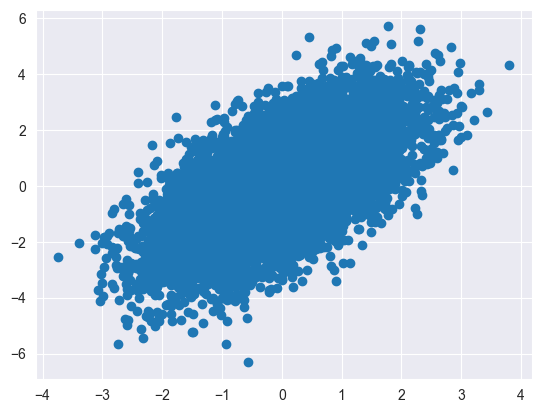

In [28]:
plt.scatter(x1, x3)
pg.partial_corr(data=df, x='x1', y='x3', covar=[]).round(3)

The p-value is significant (smaller than $\alpha = 0.05$) so we reject the null hypothesis (and we *accept* the alternative one) and establish that $X_1 \not \!\perp\!\!\!\perp X_3$, which means that keep the edge between them. The plot also shows a correlation tendency.

The following cell goes through the whole edge list and remove the edges when two nodes are independent.

removing edge:  ('x1', 'x2')
removing edge:  ('x2', 'x4')


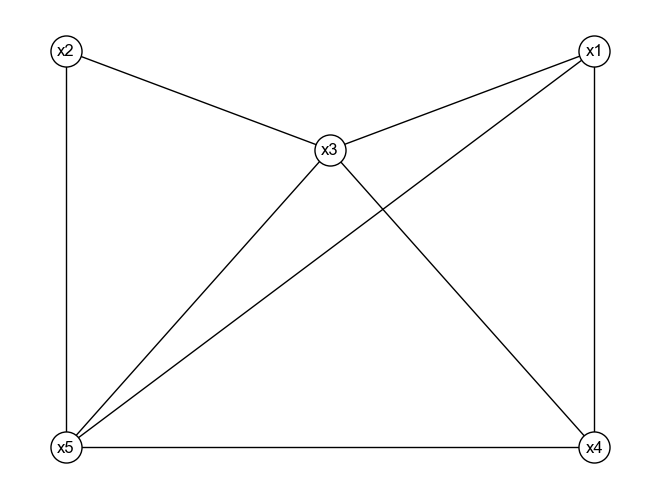

In [29]:
first_round_removed_edges = []
for (x, y) in combinations(skeleton.nodes(), 2):
    res = pg.partial_corr(data=df, x=x, y=y, covar=[]).round(3)
    if res['p-val'].item() > alpha:
        first_round_removed_edges.append((x, y))
        print("removing edge: ", (x, y))
        # Fail to reject null hypothesis of independence between x and y, thus we remove the edge (x,y)
        if skeleton.has_edge(x, y):
            skeleton.remove_edge(x, y)
nx.draw(skeleton, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

Next in **round 2**, we have conditioning set of size one. Let's start with the set $S=\{X_3\}$ and test the conditional independence $X_1 \!\perp\!\!\!\perp X_5 | X_3$.

In [30]:
pg.partial_corr(data=df, x='x1', y='x5', covar=['x3']).round(3)

,n,r,CI95%,p-val
pearson,10000,0.015,"[-0.01, 0.03]",0.146


The non-significant p-value shows that we fail to reject the null hypothesis of $X_1 \!\perp\!\!\!\perp X_5 | X_3$, which means that we assume it holds. By the faithfulness assumption, $X_1$ and $X_5$ cannot be adjacent in the graph (since then they wouldn't be independent conditionally by any set of nodes), thus we can remove the edge between them.

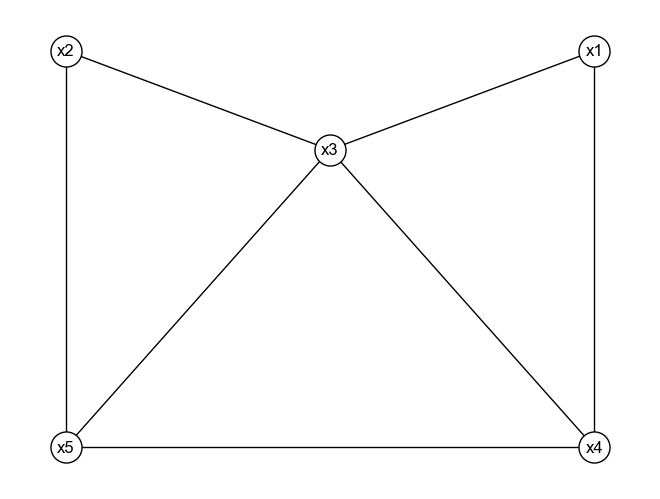

In [31]:
if skeleton.has_edge('x1', 'x5'): # safety check
    skeleton.remove_edge('x1', 'x5')
nx.draw(skeleton, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

We go through all combinations of nodes with different conditioning sets and remove edges. 

removing edge:  ('x2', 'x4')
removing edge:  ('x3', 'x4')
removing edge:  ('x4', 'x5')
removing edge:  ('x1', 'x5')
removing edge:  ('x2', 'x5')
removing edge:  ('x4', 'x5')
removing edge:  ('x1', 'x2')


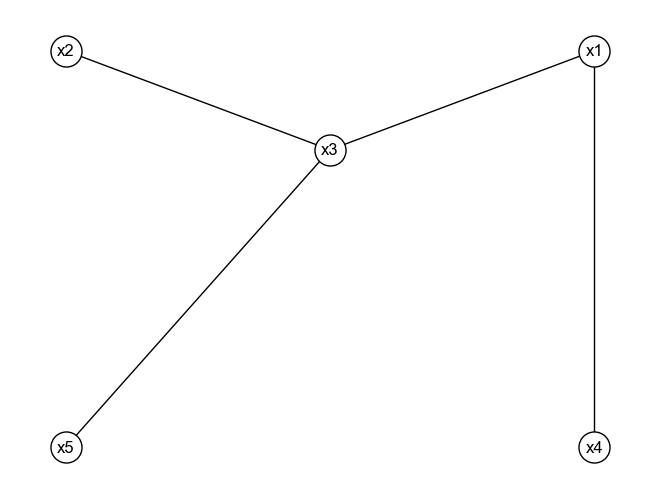

In [32]:
for z in nodes:
    for (x, y) in combinations([node for node in nodes if node != z], 2):
        res = pg.partial_corr(data=df, x=x, y=y, covar=[z]).round(3)
        p_val = res['p-val'].item()
        if p_val > alpha:
            print("removing edge: ", (x, y))
            # Fail to reject null hypothesis of conditional independence between x and y given z, thus we remove the edge (x,y)
            if skeleton.has_edge(x, y):
                skeleton.remove_edge(x, y)
                
nx.draw(skeleton, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

We can continue performing the conditional independence testing with larger and larger conditioning sets. In this example, we don't have any other independences found. The full algorithm is below.

In [33]:
def skeleton_learning(df, alpha=0.05):
    # Initialize fully connected skeleton
    skeleton = nx.Graph(combinations(list(df.columns), 2))
    # for all pairs of nodes x and y
    for (x, y) in combinations(skeleton.nodes(), 2):
        # for k = 0,1,...,|V|
        for k in range(len(skeleton.nodes())-1):
            # for all S subset of |V|\{x,y} s.t. |S|=k
            for s in combinations(set(skeleton.nodes()).difference([x,y]), k):
                # test null hypothesis of conditional independence between x and y given s
                p_val = pg.partial_corr(data=df, x=x, y=y, covar=list(s)).round(3)['p-val'].item()
                # If we fail to reject the null hypothesis then x and y cannot be adjacent
                if p_val > alpha and skeleton.has_edge(x, y):
                    print("removing edge: ", (x, y))
                    skeleton.remove_edge(x, y)
    return skeleton

removing edge:  ('x1', 'x2')
removing edge:  ('x1', 'x5')
removing edge:  ('x2', 'x4')
removing edge:  ('x2', 'x5')
removing edge:  ('x3', 'x4')
removing edge:  ('x4', 'x5')


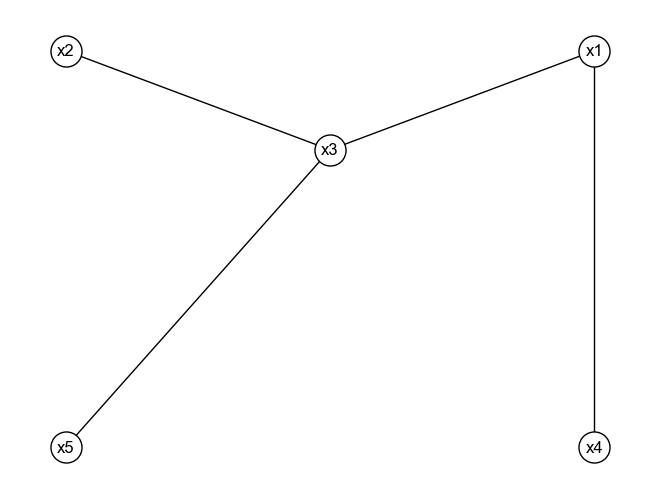

In [34]:
skeleton = skeleton_learning(df)
nx.draw(skeleton, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

### v-structures

networkX does not support mixed graphs, so we convert the undirected graph to a directed graph. We use **black** edges to indicate directed edges and **red** bi-directional edges to indicate undirected edges.

Here we manully check the v-strucures. You can also implement an algorithm with Meek rules (http://proceedings.mlr.press/v89/katz19a/katz19a-supp.pdf) to find a complete orientation.

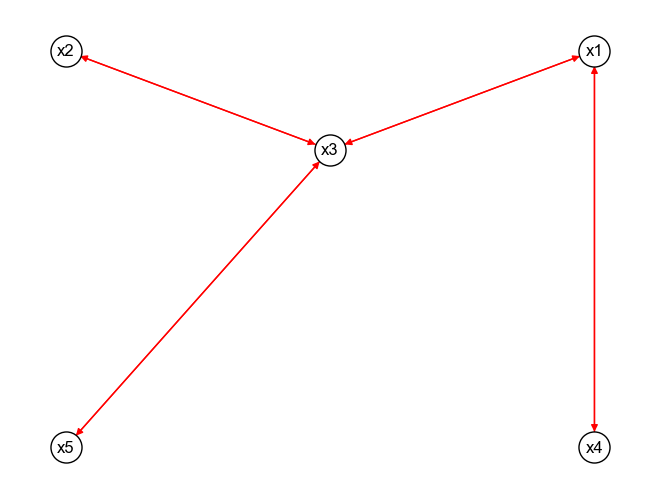

In [35]:
directed = skeleton.to_directed()
colors = ['red'  if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]
nx.draw(directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

The triple $(X_2, X_3, X_1)$ is an **unshielded triple**. Let's check if $\forall S \subseteq V \setminus \{X_2, X_3, X_1\}$, the conditional dependence $X_2 \not \!\perp\!\!\!\perp X_1 | X_3 \cup S$ holds.

In [36]:
print('p-val for S={}: ' + str(pg.partial_corr(data=df, x='x2', y='x1', covar=['x3']).round(3)['p-val'].item()))
print('p-val for S={x4}: ' + str(pg.partial_corr(data=df, x='x2', y='x1', covar=['x3', 'x4']).round(3)['p-val'].item()))
print('p-val for S={x5}: ' + str(pg.partial_corr(data=df, x='x2', y='x1', covar=['x3', 'x5']).round(3)['p-val'].item()))
print('p-val for S={x4, x5}: ' + str(pg.partial_corr(data=df, x='x2', y='x1', covar=['x3', 'x4', 'x5']).round(3)['p-val'].item()))

p-val for S={}: 0.0
p-val for S={x4}: 0.0
p-val for S={x5}: 0.0
p-val for S={x4, x5}: 0.0


As the results above show, we can always reject the null hypothesis of independence and establish that $(X_2, X_3, X_1)$ is a v-structure, orienting the edges as $X_2 \to X_3$ and $X_1 \to X_3$.

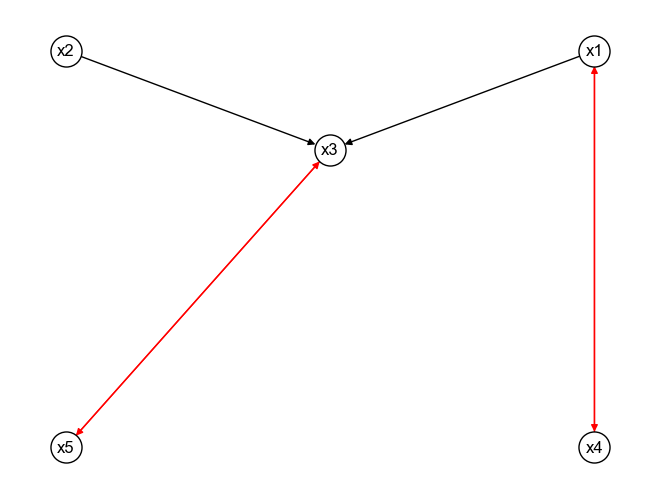

In [37]:
directed.remove_edges_from([('x3', 'x2'), ('x3', 'x1')])
colors = ['red'  if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]
nx.draw(directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

### Meek's rules

Because there are no other v-structures, Meek's rule 1 tells us that the edge $X_5 \to X_3$ cannot exist, as it will create an additional v-structure. Thus, we can orient the edge as $X_3 \to X_5$. Unfortunately, Meek's rules don't tell us anything about the edge between $X_1$ and $X_4$.

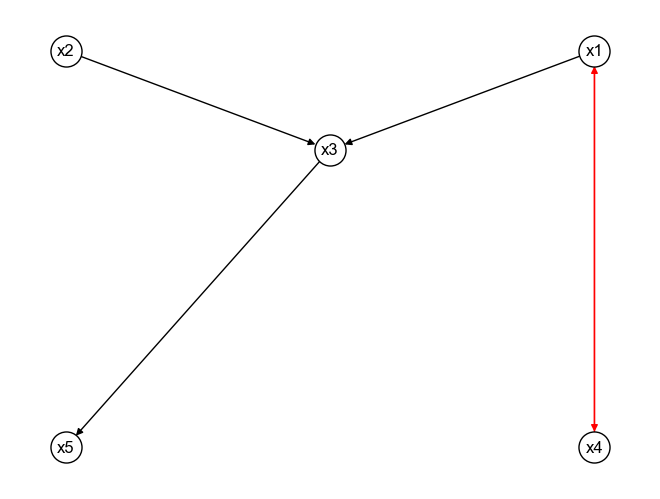

In [38]:
directed.remove_edge('x5', 'x3')
colors = ['red'  if (y,x) in directed.edges() else 'black' for (x,y) in directed.edges()]
nx.draw(directed, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

**The full PC algorithm is available in the CausalDiscoveryTool (cdt) package**. The default CItest we use here is Gaussion CI test. There is also a list of options possible for different CI tests.
```CI_test = {'binary': "pcalg::binCItest", 
             'discrete': "pcalg::disCItest",
             'hsic_gamma': "kpcalg::kernelCItest",
             'hsic_perm': "kpcalg::kernelCItest",
             'hsic_clust': "kpcalg::kernelCItest",
             'gaussian': "pcalg::gaussCItest",
             'rcit': "RCIT:::CItest",
             'rcot': "RCIT:::CItest"}```

In [39]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
pc_graph = pc.create_graph_from_data(df)
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)


R Python Error Output 
-----------------------

[Errno 2] No such file or directory: '/var/folders/0r/z84cbr615yj03ct83zl_dq580000gn/T/cdt_pc_6a071661-94e4-40cb-a0a1-112c8901fc14/result.csv'


RuntimeError: RProcessError 
R Process Error Output 
-----------------------


The results from the PC algorithm is a Markov equivalence class (MEC) that contains two valid DAGs, one of which is the true causal graph. We are not able to orient the edge between $X_1$ and $X_2$ purely based on the observed data. In general, the PC algorithm works well with the number of nodes smaller than 200, but is sensitive to conditional independence tests and the number of samples.

### Background knowledge

In many applications background knowledge of the causal system is available. This information is typically of two kinds: Either it is known that a certain edge must or must not be present, or the orientation of a certain edge is known. For the example above, if we have the knowledge that $X_4$ cannot cause $X_1$, then we are able to orient the edge and therefore obtain the DAG.

In [ ]:
pc_graph.remove_edge('x4', 'x1')
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos)

#### Optional: Running PC with background knowledge
In our example, adding background knowledge retrospecitvely resulted in a fully oriented graph. However, in general, orienting edges "manually" can result in mixed graphs in which Meek's rules can be applied again. Thus, it is best if background knowledge about edges is stated before applying SGS/PC. In `cdt` (and in the underlying `pcalg` package) we can only add the prior knowledge about the (non-)existence of edges, but not about their orientation. An example where the skeleton learning of the PC algorithm is forced to never remove the edge between $X_2$ and $X_5$ is shown below.

In [ ]:
pc = cdt.causality.graph.PC(CItest="gaussian", alpha=alpha)
### Define background knowledge ###
prior_graph = nx.DiGraph() # Create a graph to hold our background knowledge
prior_graph.add_nodes_from(['x1', 'x2', 'x3', 'x4', 'x5']) # Add nodes
prior_graph.add_edges_from([('x2', 'x5'), ('x5', 'x2')]) # Add prior knowledge of edge between X_2 and X_5 existing
fixed_edges = pd.DataFrame(nx.adjacency_matrix(prior_graph).todense()) # Symmetric adjacency matrix representing edges that exist
fixed_gaps = pd.DataFrame(np.zeros((5,5), dtype=int)) # Symmetric adjacency matrix representing edges that canNOT exist
### Run PC ###
pc.arguments['{CITEST}'] = pc.dir_CI_test[pc.CI_test]
pc.arguments['{METHOD_INDEP}'] = pc.dir_method_indep[pc.CI_test]
pc.arguments['{DIRECTED}'] = 'TRUE'
pc.arguments['{ALPHA}'] = str(pc.alpha)
pc.arguments['{NJOBS}'] = str(pc.njobs)
result = pc._run_pc(df, fixedEdges=fixed_edges, fixedGaps=fixed_gaps)
pc_graph = nx.relabel_nodes(nx.DiGraph(result), {idx: i for idx, i in enumerate(df.columns)})
### Visalise ###
colors = ['red'  if (y,x) in pc_graph.edges() else 'black' for (x,y) in pc_graph.edges()]
nx.draw(pc_graph, with_labels=True, node_size=500, node_color='w', edgecolors ='black', pos=pos, edge_color=colors)

As we can see, the graph above contains the edge $X_2 \to X_5$, as required by our prior knowledge.

### Estimating in DoWhy

We can then use this graph in DoWhy and carry on causal effect estimation. Note that we can only use DAGs in DoWhy for the causal model. If the outputs from the PC algorithm are not DAGs then we are not able to use them directly in DoWhy.

In [ ]:
gml = ''.join(nx.generate_gml(pc_graph))
model = CausalModel(
        data = df,
        treatment='x2',
        outcome='x5',
        graph=gml)
model.view_model()

In [ ]:
identified_estimand = model.identify_effect()
print(identified_estimand)

In [ ]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression")
print("Causal Estimate is " + str(estimate.value))